In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

first_row = session.query(Measurement).first()
first_row.__dict__

for row in session.query(Measurement.date,Measurement.prcp).limit(10).all():
    print(row)

('2010-01-01', 0.08)
('2010-01-02', 0.0)
('2010-01-03', 0.0)
('2010-01-04', 0.0)
('2010-01-06', None)
('2010-01-07', 0.06)
('2010-01-08', 0.0)
('2010-01-09', 0.0)
('2010-01-10', 0.0)
('2010-01-11', 0.01)


In [13]:
# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago ='2016-08-23'

In [27]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= year_ago).all()

In [28]:
m_date = [result[0] for result in precipitation]
m_precip = [result[1] for result in precipitation]

In [29]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame({"Date": m_date,
                        "Precipitation": m_precip})

precip_df = precip_df.dropna(inplace=False)
precip_df["Precipitation"] = precip_df["Precipitation"].astype(float)

precip_df = precip_df.set_index('Date')
precip_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


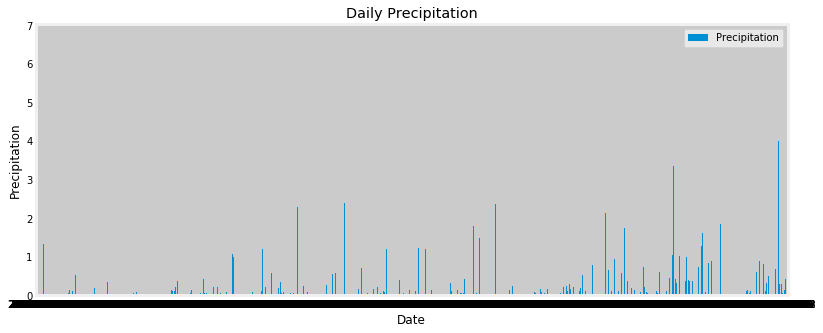

<Figure size 432x288 with 0 Axes>

In [33]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_chart = precip_df.plot(kind='bar', figsize=(12,5), title='Daily Precipitation', grid=True, legend=True, xticks=[])

# Set the xlabel and ylabel using class methods
precip_chart.set_xlabel("Date")
precip_chart.set_ylabel("Precipitation")


plt.show()
plt.tight_layout()

![precipitation](Images/precipitation.png)

In [87]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
for row in session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all():
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [34]:
station_activity = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_active = station_activity[0]
most_active

'USC00519281'

In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

In [61]:
tempmin = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active).all()
tempmin

[(54.0)]

In [62]:
tempmax = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active).all()
tempmax

[(85.0)]

In [63]:
tempavg = session.query(Measurement.station,func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()
tempavg = tempavg[0][1]
tempavg

71.66378066378067

In [16]:
station_measure = session.query(Measurement, Station).filter(Measurement.station == Station.station).\
order_by(Station.station.desc()).statement

C:\Users\Alyza\Anaconda3\lib\site-packages\sqlalchemy\sql\base.py:528: SAWarning: Column 'id' on table <sqlalchemy.sql.selectable.Select at 0x1af9ae752b0; Select object> being replaced by Column('id', INTEGER(), table=<Select object>, primary_key=True, nullable=False), which has the same key.  Consider use_labels for select() statements.
  (key, getattr(existing, 'table', None), value))
C:\Users\Alyza\Anaconda3\lib\site-packages\sqlalchemy\sql\base.py:528: SAWarning: Column 'station' on table <sqlalchemy.sql.selectable.Select at 0x1af9ae752b0; Select object> being replaced by Column('station', TEXT(), table=<Select object>), which has the same key.  Consider use_labels for select() statements.
  (key, getattr(existing, 'table', None), value))


In [28]:
station_measure_df = pd.read_sql_query(station_measure, session.bind)
station_measure_df.head(10)

,id,station,date,prcp,tobs,id,station,name,latitude,longitude,elevation
0,9519,USC00519523,2010-01-01,0.15,75.0,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,9520,USC00519523,2010-01-02,0.00,75.0,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
2,9521,USC00519523,2010-01-03,0.00,77.0,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,9522,USC00519523,2010-01-04,0.00,75.0,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,9523,USC00519523,2010-01-05,0.01,75.0,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,9524,USC00519523,2010-01-06,0.11,72.0,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,9525,USC00519523,2010-01-07,0.70,68.0,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
7,9526,USC00519523,2010-01-08,0.02,63.0,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
8,9527,USC00519523,2010-01-09,0.01,69.0,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
9,9528,USC00519523,2010-01-10,0.00,72.0,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [78]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year = session.query(Measurement.date,Measurement.tobs).\
filter(Measurement.station == most_active).filter(Measurement.date >= year_ago).all()

In [79]:
last_year_df = pd.DataFrame(last_year)
last_year_df.head() 

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


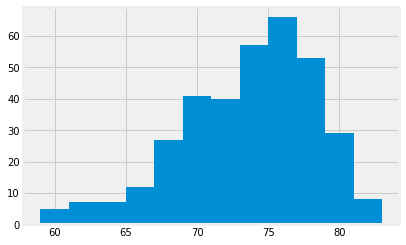

In [81]:
last_year_df['tobs'].hist(bins=12)

![precipitation](Images/station-histogram.png)

In [14]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-07-01'
end_date = '2017-07-08'

vacation = calc_temps(start_date, end_date)
vac_avg = vacation[0][2] 

In [25]:
vac_df = pd.DataFrame({"Avg" : [vac_avg]})
vac_df

,Avg
0,87.0


In [40]:
yerror = vacation[0][1]-vacation[0][0]
yerror

7.043478260869563

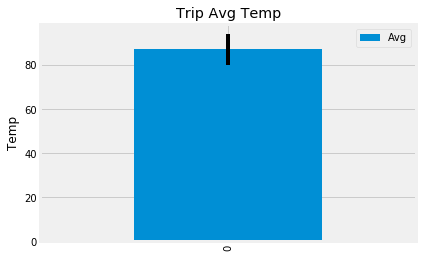

<Figure size 432x288 with 0 Axes>

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
vac_chart = vac_df.plot(kind='bar',  yerr=yerror, title='Trip Avg Temp', grid=True, legend=True)

# Set the xlabel and ylabel using class methods
vac_chart.set_ylabel("Temp")

plt.show()
plt.tight_layout()

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [128]:
start = '2010-01-30'

results = calc_temps(start, max_date)
    
results

[(53.0, 73.13661484427458, 87.0)]

In [131]:
start_dict = {"Min" : results[0][0],
              "Max" : results[0][1],
              "Avg" : results[0][2]}

In [132]:
start_dict

{'Min': 53.0, 'Max': 73.13661484427458, 'Avg': 87.0}